# Challenge 3: Artificial Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time

torch.manual_seed(0)

## 1. Data exploration

In [2]:
BATCH_SIZE = 64

data_transforms = transforms.ToTensor()

## TRAIN set
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
print(len(trainset))

## TEST set
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
print(len(testset))

60000
10000


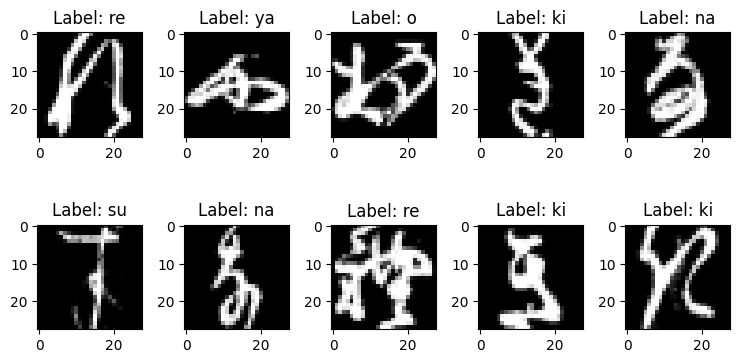

Classes: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


In [3]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

print(f'Classes: {classes}')

In [4]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## Model building

#### FULLY CONNECTED

In [5]:
class FullyConnected_1(nn.Module):
    def __init__(self):
        super(FullyConnected_1, self).__init__()

        self.l1 = nn.Linear(28 * 28, 32 * 26 * 26)  # Input size: 28*28 (dimensione immagine KMNIST)
        self.l2 = nn.Linear(32 * 26 * 26, 128)
        self.l3 = nn.Linear(128, 10)


    def forward(self, x):
        # Flatten: BSx1x28x28 => BSx(28*28)
        x = x.view(x.size(0), -1)

        # BSx(28*28) => BSx128
        x = F.relu(self.l1(x))

        # BSx128 => BSx64
        x = F.relu(self.l2(x))

        # BSx64 => BSx10
        logits = self.l3(x)

        # Softmax computation
        out = F.softmax(logits, dim=1)

        return out

#### CONVOLUTIONAL

1 hidden layer

In [6]:
class Convolutional_1(nn.Module):
    def __init__(self):
        super(Convolutional_1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)   # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.l1 = nn.Linear(32 * 12 * 12, 128)
        self.l2 = nn.Linear(128, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = x.flatten(start_dim = 1)    # flatten => BS x 4608

        x = self.l1(x)                  # Linear: BSx(32*12*12) => BSx128
        x = F.relu(x)

        logits = self.l2(x)             # Linear: BSx128 => BSx10

        # Softmax computation: ogni neurone in uscita avra un label assegnato; softmax indica la probabilita che appartenga effettivamente a quella classe
        out = F.softmax(logits, dim=1)

        return out

3 hidden layers

In [7]:
class Convolutional_3(nn.Module):
    def __init__(self):
        super(Convolutional_3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)       # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)     # 12 - kernel_size +1 = 10
        # max-pooling 2x2: 10 / 2 = 5
        self.l1 = nn.Linear(128 * 5 * 5, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = self.conv2(x)               # Convolution: BSx32x12x212 => BSx128x10x10
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx128x5x5

        x = x.flatten(start_dim = 1)    # flatten => BS x 3200

        x = self.l1(x)                  # Linear: BSx(128*5*5) => BSx256
        x = F.relu(x)

        x = self.l2(x)                  # Linear: BSx256 => BSx64
        x = F.relu(x)

        logits = self.l3(x)             # Linear: BSx64 => BSx10

        # Softmax computation: ogni neurone in uscita avra un label assegnato; softmax indica la probabilita che appartenga effettivamente a quella classe
        out = F.softmax(logits, dim=1)

        return out

#### Training cycle

In [8]:
def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer, device):

    print(f'Training model: {model.__class__.__name__} with Loss function: {criterion} and Optimizer: {optimizer.__class__.__name__}\n')

    # Rich mac user
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accs = []

    norms = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)


        losses.append(train_running_loss / i)
        accs.append(train_acc/i)

        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"\tEpoch: [{epoch+1}/{num_epochs}] | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")

    print('\n')
    return losses, accs, norms

In [9]:
num_epochs = 10
num_models = 3*2    # 3 modelli, 2 ottimizzatori
#learning_rates = [0.001, 0.01, 0.1]
learning_rates = [0.00001]#, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3]
criterion = nn.CrossEntropyLoss()

losses = []
accuracies = []
weight_norms = []
optimizer_names = ['SGD', 'Adam']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:

    print('-'*90)
    print(f'Training with learning rate: {lr}')
    print(f'Using device: {device}' if device=='cpu' else f'Using device: {device} ({torch.cuda.get_device_name()})')
    print('-'*90)
    print()

    losses_lr = []
    accuracies_lr = []
    weight_norms_lr = []

    for model_index in range(0, num_models, 2):

        # devo re-instanziarli ad ogni ciclo, altrimenti il training non si resetta ma continua da dove aveva terminato quello precedente
        models = [FullyConnected_1(), FullyConnected_1(), Convolutional_1(), Convolutional_1(), Convolutional_3(), Convolutional_3()]

        loss_sgd, acc_sgd, W_sgd = train_model(models[model_index], num_epochs, trainloader, criterion, torch.optim.SGD(models[model_index].parameters(), lr=lr), device)
        loss_adam, acc_adam, W_adam = train_model(models[model_index+1], num_epochs, trainloader, criterion, torch.optim.Adam(models[model_index+1].parameters(), lr=lr), device)

        losses_lr.extend([loss_sgd, loss_adam])
        accuracies_lr.extend([acc_sgd, acc_adam])
        weight_norms_lr.extend([W_sgd, W_adam])

    losses.append(losses_lr)
    accuracies.append(accuracies_lr)
    weight_norms.append(weight_norms_lr)

    print()

------------------------------------------------------------------------------------------
Training with learning rate: 1e-05
Using device: cuda (AMD Radeon RX 7800 XT)
------------------------------------------------------------------------------------------

Training model: FullyConnected_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/10] | Loss: 2.3052 | Train Accuracy: 11.3861 | Time: 5.52
	Epoch: [2/10] | Loss: 2.3051 | Train Accuracy: 11.5345 | Time: 5.08
	Epoch: [3/10] | Loss: 2.3051 | Train Accuracy: 11.6879 | Time: 5.08
	Epoch: [4/10] | Loss: 2.3050 | Train Accuracy: 11.8246 | Time: 5.12
	Epoch: [5/10] | Loss: 2.3050 | Train Accuracy: 11.9914 | Time: 5.23
	Epoch: [6/10] | Loss: 2.3049 | Train Accuracy: 12.2232 | Time: 5.18
	Epoch: [7/10] | Loss: 2.3049 | Train Accuracy: 12.4333 | Time: 5.18
	Epoch: [8/10] | Loss: 2.3048 | Train Accuracy: 12.6684 | Time: 5.11
	Epoch: [9/10] | Loss: 2.3048 | Train Accuracy: 12.8702 | Time: 5.12
	Epoch: [10/10] | Loss: 2.

In [10]:
print(device)

cuda


## Tables
3. Summarise your results in a table and comment on them in the report.

In [11]:
models_for_table = [[FullyConnected_1(), FullyConnected_1()], [Convolutional_1(), Convolutional_1()], [Convolutional_3(), Convolutional_3()]]
num_models = len(models_for_table)         # number of models: in this case, 3 (FullyConnected_1, Convolutional_1, Convolutional_3)
num_optimizers = len(optimizer_names)      # number of optimizers: in this case, 2 (SGD and Adam)
num_rows = num_epochs * num_models * num_optimizers

pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_rows', None)     # To display all rows

for lr_index, lr in enumerate(learning_rates):
    
    print(f'\nLearning rate: {lr}')

    table = pd.DataFrame({'Model' : [models_for_table[i][0].__class__.__name__ for i in range(num_models) for j in range(num_epochs*num_optimizers)],
            'Optimizer' : [optimizer_names[i] for k in range(num_models) for i in range(num_optimizers) for j in range(num_epochs)],
            'Epoch': [i % (num_epochs) + 1 for i in range(num_rows)],
            'Loss': [losses[lr_index][i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
            'Accuracy (train)': [accuracies[lr_index][i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
            })

    separator = pd.DataFrame({'Model' : ['---'],
            'Optimizer' : ['---'],
            'Epoch': ['---'],
            'Loss': ['---'],
            'Accuracy (train)': ['---'],
            })

    for i in range(num_optimizers*num_epochs, num_rows, num_optimizers*num_epochs+1):
        table = pd.concat([table.iloc[:i], separator, table.iloc[i:]]).reset_index(drop=True)

    print(table)
    print('-'*64)


Learning rate: 1e-05
               Model Optimizer Epoch      Loss Accuracy (train)
0   FullyConnected_1       SGD     1  2.305154        11.386073
1   FullyConnected_1       SGD     2  2.305107        11.534485
2   FullyConnected_1       SGD     3   2.30506          11.6879
3   FullyConnected_1       SGD     4  2.305014         11.82464
4   FullyConnected_1       SGD     5  2.304966        11.991395
5   FullyConnected_1       SGD     6  2.304919        12.223186
6   FullyConnected_1       SGD     7  2.304873        12.433298
7   FullyConnected_1       SGD     8  2.304824        12.668423
8   FullyConnected_1       SGD     9  2.304777        12.870197
9   FullyConnected_1       SGD    10  2.304731        13.081977
10  FullyConnected_1      Adam     1  1.838012         72.09345
11  FullyConnected_1      Adam     2  1.679531        80.794757
12  FullyConnected_1      Adam     3  1.655332        82.447305
13  FullyConnected_1      Adam     4  1.641059        83.636273
14  FullyConnected

## RIASSUNTO TABELLE
- I learning rate 5 e 10 fanno cacare sempre, possiamo toglierli
- Convolutional_3 SGD fa sempre cacare, si blocca su accuracy 10
- SGD con lr=0.1: Convolutional_3
- SGD con lr=0.5: Convolutional_1
- SGD con lr=1:   FullyConnected_1
- Tutti gli Adam con lr >= 0.01 si bloccano su accuracy 10 (a volte peggiorando)
- Adam con lr=0.0001: FullyConnected_1 (di parecchio)
- Adam con lr=0.001:  Convolutional_1


## Plotting
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [19]:
# VA INSERITO IL MODELLO CHE SCEGLIAMO
model = Convolutional_3()
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss, accuracies, W = train_model(model, num_epochs, trainloader, criterion, optimizer, device)

Training model: Convolutional_3 with Loss function: CrossEntropyLoss() and Optimizer: Adam

	Epoch: [1/10] | Loss: 1.6655 | Train Accuracy: 80.1194 | Time: 5.06
	Epoch: [2/10] | Loss: 1.5653 | Train Accuracy: 89.9096 | Time: 4.98
	Epoch: [3/10] | Loss: 1.5406 | Train Accuracy: 92.3626 | Time: 5.07
	Epoch: [4/10] | Loss: 1.5187 | Train Accuracy: 94.5588 | Time: 4.97
	Epoch: [5/10] | Loss: 1.4992 | Train Accuracy: 96.5165 | Time: 5.15
	Epoch: [6/10] | Loss: 1.4920 | Train Accuracy: 97.2018 | Time: 5.22
	Epoch: [7/10] | Loss: 1.4903 | Train Accuracy: 97.3536 | Time: 5.19
	Epoch: [8/10] | Loss: 1.4886 | Train Accuracy: 97.5220 | Time: 5.09
	Epoch: [9/10] | Loss: 1.4882 | Train Accuracy: 97.5570 | Time: 4.96
	Epoch: [10/10] | Loss: 1.4871 | Train Accuracy: 97.6754 | Time: 4.98




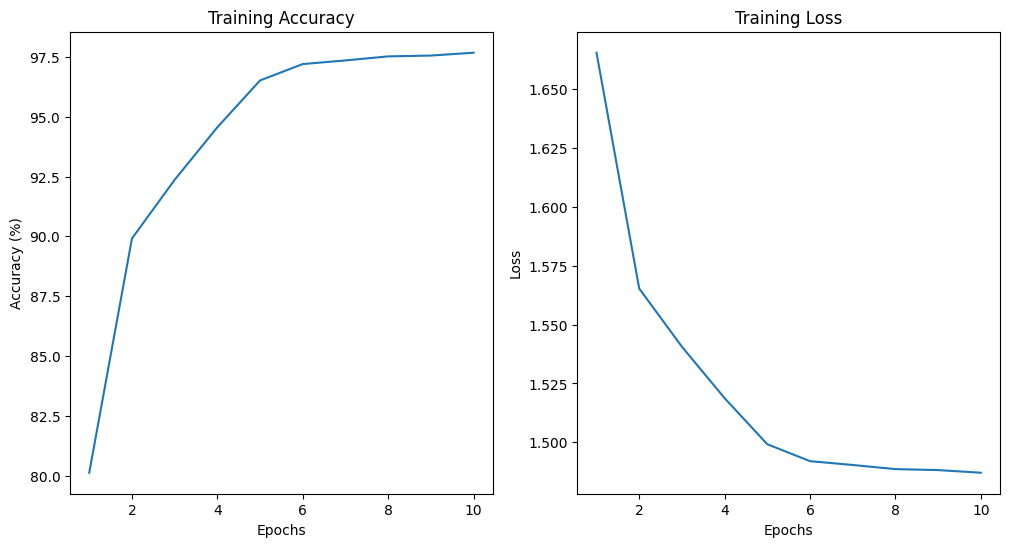

In [20]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), accuracies)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training Accuracy')

ax2.plot(range(1, num_epochs+1), loss)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss')

# plt.tight_layout()
plt.show()

Test Accuracy: 93.0889
Test Loss: 1.5456


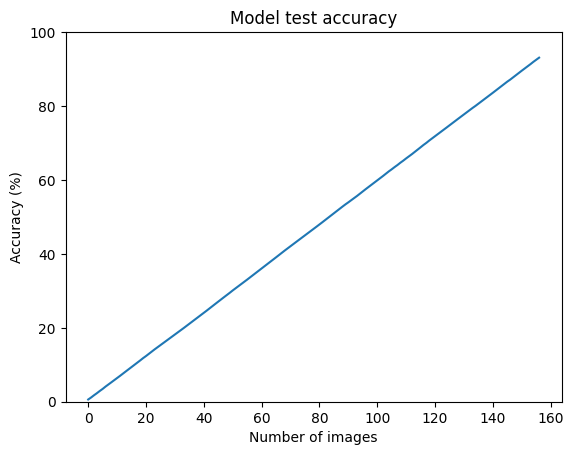

In [21]:
test_running_acc = 0.0
test_running_loss = 0.0
test_accuracy = []
test_loss = []
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_running_loss += loss.item()/(len(testloader) - 1)
    test_running_acc += get_accuracy(outputs, labels)/(len(testloader) - 1)

    test_accuracy += [test_running_acc]
    test_loss += [test_running_loss]

print(f"Test Accuracy: {test_running_acc:.4f}")
print(f"Test Loss: {test_running_loss:.4f}")

# Plot dell'accuracy
plt.plot(test_accuracy)
plt.ylim(0, 100)
plt.xlabel('Number of images')
plt.ylabel('Accuracy (%)')
plt.title('Model test accuracy')
plt.show()

In [12]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''

'test_acc = 0.0\nfor i, (images, labels) in enumerate(testloader, 0):\n    images = images.to(device)\n    labels = labels.to(device)\n    outputs = model(images)\n    test_acc += get_accuracy(outputs, labels)\n\nprint(f"Test Accuracy: {test_acc/i:.4f}")'

In [13]:
'''# Number of times the whole (training) dataset is used for training
model = Convolutional_3()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


_, acc_adam, W_adam, device = train_model(model, num_epochs, trainloader, criterion, optimizer, learning_rate)'''

'# Number of times the whole (training) dataset is used for training\nmodel = Convolutional_3()\noptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n\n\n_, acc_adam, W_adam, device = train_model(model, num_epochs, trainloader, criterion, optimizer, learning_rate)'

In [14]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''

'test_acc = 0.0\nfor i, (images, labels) in enumerate(testloader, 0):\n    images = images.to(device)\n    labels = labels.to(device)\n    outputs = model(images)\n    test_acc += get_accuracy(outputs, labels)\n\nprint(f"Test Accuracy: {test_acc/i:.4f}")'

In [15]:
'''model = FullyConnected()
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

_, acc_SGD, W_SGD = train_model(model, num_epochs, trainloader, criterion, optimizer)'''

'model = FullyConnected()\nnum_epochs = 5\nlearning_rate = 0.001\n\ncriterion = nn.CrossEntropyLoss() # loss function\noptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n\n_, acc_SGD, W_SGD = train_model(model, num_epochs, trainloader, criterion, optimizer)'

In [16]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''

'test_acc = 0.0\nfor i, (images, labels) in enumerate(testloader, 0):\n    images = images.to(device)\n    labels = labels.to(device)\n    outputs = model(images)\n    test_acc += get_batch_accuracy(outputs, labels)\n\nprint(f"Test Accuracy: {test_acc/i:.4f}")'